(173, 2)
prix           float64
date    datetime64[ns]
dtype: object
         prix
count  173.00
mean    20.24
std      1.55
min     17.19
25%     18.84
50%     20.33
75%     21.66
max     22.75


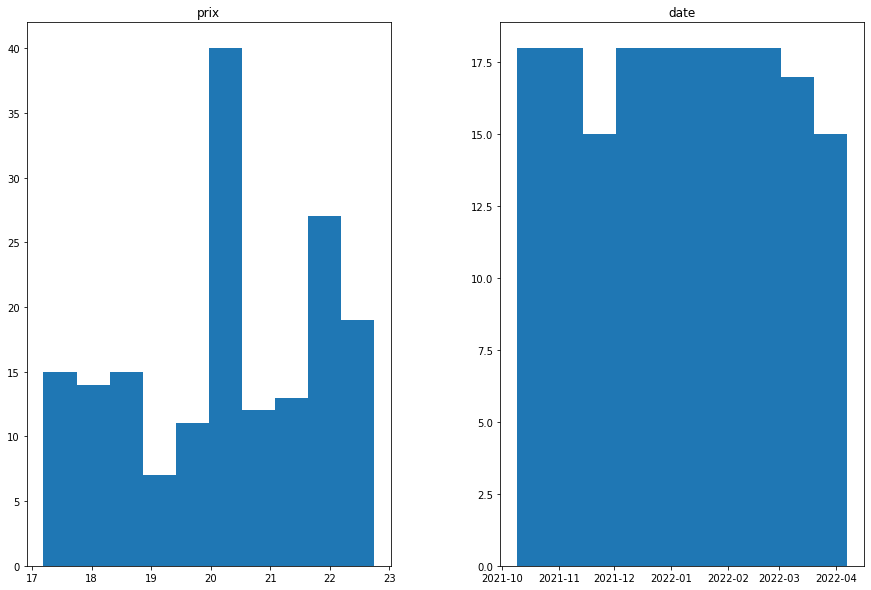

17.18995290423862 0.93250407189056 0.9200297381900202
17.22303206997085 0.93250407189056 0.9200297381900202
17.256111235703074 0.93250407189056 0.9200297381900202
17.289190401435302 0.93250407189056 0.9200297381900202
17.322269567167528 0.93250407189056 0.9200297381900202
17.355348732899756 0.93250407189056 0.9200297381900202
17.38842789863198 0.93250407189056 0.9200297381900202
17.42150706436421 0.93250407189056 0.9200297381900202
17.454586230096435 0.93250407189056 0.9200297381900202
17.487665395828664 0.93250407189056 0.9200297381900202
17.52074456156089 0.93250407189056 0.9200297381900202
17.553823727293118 0.93250407189056 0.9200297381900202
17.586902893025343 0.93250407189056 0.9200297381900202
17.61998205875757 0.93250407189056 0.9200297381900202
17.653061224489797 0.93250407189056 0.9200297381900202
17.686140390222025 0.93250407189056 0.9200297381900202
17.71921955595425 0.93250407189056 0.9200297381900202
17.75229872168648 0.93250407189056 0.9200297381900202
17.785377887418704

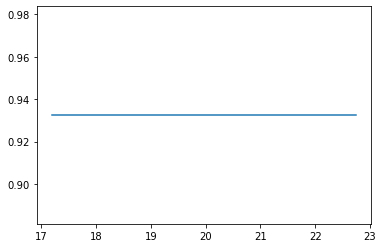

In [28]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import *
import sklearn.linear_model
import sklearn.preprocessing
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.ion()

def convert_datelist_counterlist(list_date):
    liste = []
    cpt = 0
    for date in list_date:
        liste.append(cpt)
        cpt = cpt+1
    return liste

filename = "ak-47-asiimov-field-tested_buff.csv"
dataset = pd.read_csv(filename)

dataset["prix"] = dataset["prix"].astype(float)
dataset["date"] = pd.to_datetime(dataset["date"])

# analyses sommaires
print(dataset.shape)

# on consulte les types des données:
print(dataset.dtypes)

# aperçu des stats de chaque colonne
pd.set_option('precision', 2)
print(dataset.describe())

# histograms
dataset.hist(bins=10,figsize=(15,10),grid=False)
plt.show()

# Setting X and Y axis
x = dataset['date'].values
x = x.reshape(-1,1)
y = dataset['prix'].values

# Train / Validation / Test split (60%/20%/20%)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=7)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=8) # 0.25 x 0.8 = 0.2


alpha_values = np.linspace(dataset['prix'].min(), dataset['prix'].max(), dataset['prix'].idxmax()) # tous les datasets font env. 180 lignes donc on peut se permettre une telle simplification

# to make score method working well
X_val = X_val.astype(np.dtype('float32'))
X_train = X_train.astype(np.dtype('float32'))
X_test = X_test.astype(np.dtype('float32'))

scores = []
for alpha in alpha_values:
    # alpha est fixé (comme mu=mu0)
    monModele = sklearn.linear_model.Ridge(alpha=alpha)
    
    # je converge theta vers theta^*
    monModele.fit(X_train, Y_train)
    
    score = monModele.score(X_val, Y_val)
    scores.append(score)
    print(alpha, score, monModele.score(X_train, Y_train))

plt.plot(alpha_values, scores)
alpha_etoile = np.argmax(np.array(scores))
print(np.array(alpha_values)[alpha_etoile])

monModele = sklearn.linear_model.Ridge(alpha=alpha_etoile)
monModele.fit(X_train, Y_train)
print(monModele.score(X_train, Y_train), monModele.score(X_val, Y_val), monModele.score(X_test, Y_test))

Y_train_pred = monModele.predict(X_train)
print("train error", sklearn.metrics.mean_squared_error(Y_train_pred, Y_train))

Y_test_pred = monModele.predict(X_test)
print("test error", sklearn.metrics.mean_squared_error(Y_test_pred, Y_test))

